# Goodreads Non-negative Matrix Factorization Models

The aim of this notebook is to collect the user-book ratings into a matrix $V$ with rows indexed by the ordered set of users $U$, ordered by `user_id`, and columns indexed by the ordered set of books $B$, ordered by `book_id`. As the set of ratings $R$ are integers 1 – 5, we consider no rating to be a 0 in this representation. Given the matrix $V$, a baseline model we consider is the mean book rating, that is, the mean along columns, as a recommendation value; these recommendations are identical across users.

Denote the number of users and books by $n_u = |U|$ and $n_b = |B|$ respectively. The models we construct are matrix factorizations of $V \in \mathsf{M}_{n_u \times n_b} (R)$, where $R$ is the set of rating values. A choice of the number of latent factors, $k$, as well as hyperparameter choices, determine a *matrix factorization model*, which is a factorization of $V$ into a matrix $W \in \mathsf{M}_{n_u \times k} (\mathbb{R}_{\geq 0})$ and a matrix $H \in \mathsf{M}_{k \times n_b} (\mathbb{R}_{\geq 0})$ such that $V \approx WH$.

To be more explicit, we represent $V \in \mathsf{M}_{n_u \times n_b} (\mathbb{R}_{\geq 0})$ and use the [non-negative matrix factorization](https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf) implementation of scikit-learn, [sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), to return two matrices $W$ and $H$ minimizing the loss function
$$
\mathcal{L} = \frac{1}{2} \| V - WH \|_F^2,
$$
where $\| \bullet \|_F$ is the Frobenius norm
$$
\| X \|_F = \sqrt{ \sum_{i, j} X_{ij}^2},
$$
that is, the $L2$-norm. [Lee and Seung 2001](http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf) describes the algorithms used by scikit-learn for matrix factorization.

In minimizing $\mathcal{L}$, we are minimizing the root-mean-square error (RMSE) between $V$ and $WH$. In analogy to [ElasticNet](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), we also explore $L1$- and $L2$-regularization in [hyperparameters](), in which we minimize the loss function
$$
\mathcal{L}_{\text{reg}} = \frac{1}{2} \| V - WH \|_F^2 + \lambda_1 (\|W\|_1 + \|H\|_1) + \lambda_2 \cdot \frac{1}{2} (\|W\|_F^2 + \|H\|_F^2),
$$
where $\| \bullet \|_1$ is the $L1$-norm
$$
\| X \|_1 = \sum_{i, j} |X_{ij}|
$$
and $\lambda_1, \lambda_2 \in \mathbb{R}_{\geq 0}$ are hyperparameters.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

raw_data_path = './data/raw/goodbooks-10k/'
model_output_path = './data/models/'
image_output_path = './image/goodreads-models/'

# raw_data_path = '../input/'
# model_output_path = ''
# image_output_path = ''

ratings_df = pd.read_csv(raw_data_path + 'ratings.csv',
                         dtype={
                             'rating': np.uint8,
                             'user_id': np.uint16,
                             'book_id': np.uint16
                         })

## User-Book Ratings Matrix

First we construct the sparse matrix, $V$, from `ratings.csv`.

In [2]:
from scipy.sparse import csr_matrix
from scipy.sparse import linalg

import matplotlib.pyplot as plt

# Create ratings matrix
ratings_matrix = csr_matrix(
    (ratings_df.rating.values, ((ratings_df.user_id.values - 1),
                                (ratings_df.book_id.values - 1))),
    dtype=np.uint8)

# Store ratings values; 0 represents no rating
values = [0, 1, 2, 3, 4, 5]

In [3]:
shape = ratings_matrix.get_shape()
print('The dimensions of the user-book ratings matrix are: ' + str(shape))

The dimensions of the user-book ratings matrix are: (53424, 10000)


In [4]:
scores = {}

def compute_scores(matrix, sparse=True, density=True):
    """Compute density and RMSE for storage in dict (of dicts)"""

    if density == True:
        density = matrix.count_nonzero() / (shape[0] * shape[1])
        print('The density of the matrix is: %.4f' % density)

    if sparse == True:
        rmse = linalg.norm(ratings_matrix - matrix)
    else:
        rmse = np.linalg.norm(ratings_matrix - matrix)
    print('The RMSE between the matrix and the user-book ratings matrix is: %.2f' % rmse)

    return {'rmse': rmse, 'density': density}

In [5]:
# Norm || 2 * R - R || = ||R||
scores['ratings'] = compute_scores(2 * ratings_matrix)

The density of the matrix is: 0.0112
The RMSE between the matrix and the user-book ratings matrix is: 9884.39


This is in fact the norm of `ratings_matrix`.

In [6]:
def make_matrix_plot(ax, matrix, sparse=True, cmap='magma', colorbar=True,
                     row_size=400, col_size=400, row_shift=0, col_shift=0, shrink=0.82,
                     title=None, xlabel='book_id', ylabel='user_id',
                     show_xticks=True, show_yticks=True):
    """Use matplotlib to make square plots of matrices."""
    
    # Get array and plot. matplotlib extend may be better
    if sparse == True:
        im = ax.imshow(matrix.toarray()[row_shift:row_shift+row_size,
                                        col_shift:col_shift+col_size], 
                       cmap=cmap)
    else:
        im = ax.imshow(matrix[row_shift:row_shift+row_size,
                              col_shift:col_shift+col_size], 
                       cmap=cmap)
    
    # Create colorbar
    if colorbar == True:
        cbar = ax.figure.colorbar(im, ax=ax, shrink=shrink)    
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    
    # Shift labels to match
    xticks = ax.get_xticks()
    xlabels = list(np.array(xticks) + col_shift)
    ax.set_xticklabels(xlabels)

    # Remove ticks
    # Not working :-?
    if show_xticks == False:
        ax.set_xticks([])

    yticks = ax.get_yticks()
    ylabels = list(np.array(yticks) + row_shift)
    ax.set_yticklabels(ylabels)
    
    # Remove ticks
    # Not working :-?
    if show_xticks == False:
        ax.set_yticks([])    

    return ax

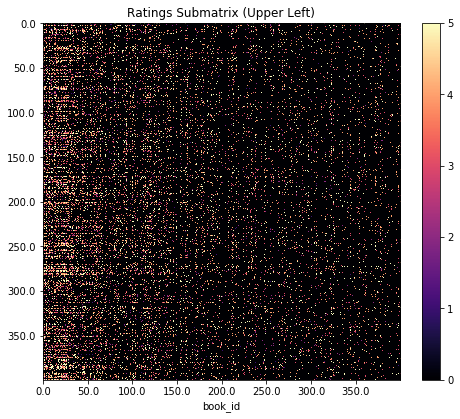

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
make_matrix_plot(ax, ratings_matrix,
                 title='Ratings Submatrix (Upper Left)')
plt.savefig(image_output_path + 'ratings-submatrix-upper-left.png', bbox_inches='tight', dpi=300)

The `book_id`s are sorted by ratings count in `books.csv` so this patch is much more dense than a patch of the matrix further right. Below is a plot of the first 500 `user_id`s and `book_id`s 5001 – 5500.

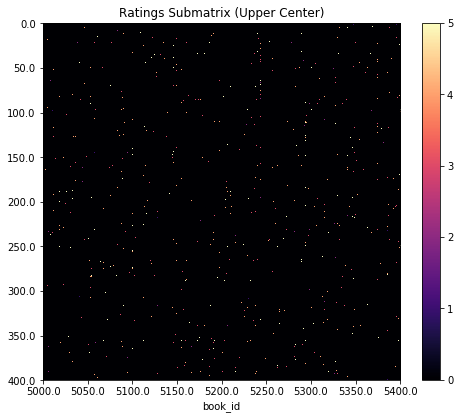

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
make_matrix_plot(ax, ratings_matrix, col_shift=5000, 
                 title='Ratings Submatrix (Upper Center)')
plt.savefig(image_output_path + 'ratings-submatrix-upper-center.png', bbox_inches='tight', dpi=300)

## Random Recommendations

Let's build a couple terrible models which merely make random recommendations so we can get an idea of what sub-baseline performance means.

### Uniformly Random Recommendations
Here we make uniformly random recommendations on a uniformly random subset of user-book entries of specified proportion (`density`).

In [9]:
# Choose density matching that of ratings_matrix
density = scores['ratings']['density']

In [10]:
# Define distribution
uniform_density = 0.2 * density
uniform_weights = [1 - density] + 5 * [uniform_density]

# Create uniform matrix
uniform_matrix = csr_matrix(np.random.choice(values,
                                             size=shape,
                                             p=uniform_weights),
                            dtype=np.uint8)

In [11]:
scores['uniform_1'] = compute_scores(uniform_matrix)

The density of the matrix is: 0.0112
The RMSE between the matrix and the user-book ratings matrix is: 12722.18


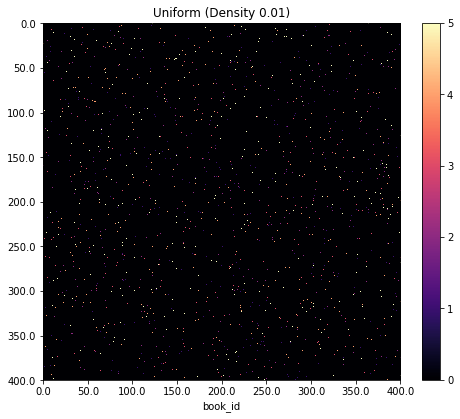

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
make_matrix_plot(ax, uniform_matrix, title='Uniform (Density 0.01)')
plt.savefig(image_output_path + 'uniform-submatrix-01.png', bbox_inches='tight', dpi=300)

In fact a density this low is undesirable since we expect that we can make as many recommendations to a given user as the mean books read per user. We would likely want to be able to recommend more books than the mean user has read. Since this model does not approximate `ratings_matrix`, and no rating is encoded as 0, increasing density to something more realistic only increases error.

In [13]:
# Choose density ten times that of ratings_matrix
density = 10 * scores['ratings']['density']

In [14]:
# Define distribution
uniform_density = 0.2 * density
uniform_weights = [1 - density] + 5 * [uniform_density]

# Create uniform matrix
uniform_matrix = csr_matrix(np.random.choice(values,
                                             size=shape,
                                             p=uniform_weights),
                            dtype=np.uint8)

In [15]:
scores['uniform_10'] = compute_scores(uniform_matrix)

The density of the matrix is: 0.1119
The RMSE between the matrix and the user-book ratings matrix is: 27194.06


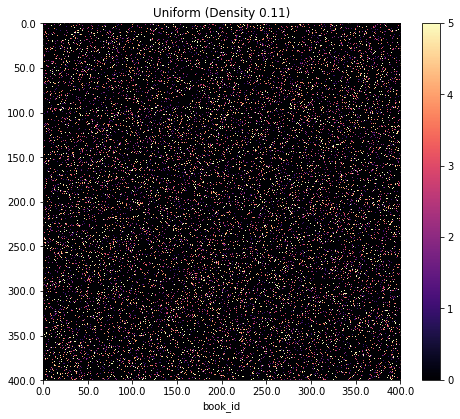

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
make_matrix_plot(ax, uniform_matrix, title='Uniform (Density 0.11)')
plt.savefig(image_output_path + 'uniform-submatrix-11.png', bbox_inches='tight', dpi=300)

In [17]:
# Cleanup
del uniform_matrix

It's interesting to note that weighting the recommendations by the distribution of user ratings actually makes RMSE worse. This is because the user ratings are left-skew, mostly 4s and 5s, while we encode no rating as 0.

In [18]:
density = scores['ratings']['density']

In [19]:
# Compute weights from ratings.csv
weights_book = ratings_df['rating'].value_counts(
    sort=False) / ratings_df['rating'].count()
weights_book = [1 - density] + list(density * weights_book)
weighted_matrix = csr_matrix(np.random.choice(values,
                                              size=shape,
                                              p=weights_book),
                             dtype=np.uint8)

In [20]:
scores['weighted_1'] = compute_scores(weighted_matrix)

The density of the matrix is: 0.0112
The RMSE between the matrix and the user-book ratings matrix is: 13904.07


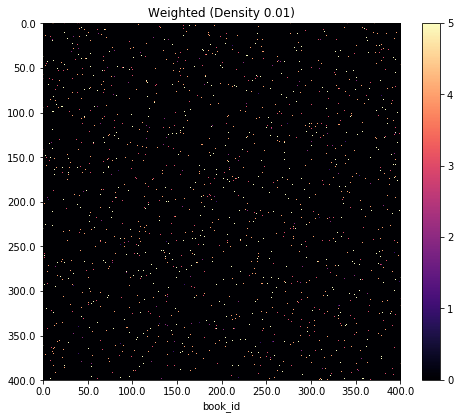

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
make_matrix_plot(ax, weighted_matrix, title='Weighted (Density 0.01)')
plt.savefig(image_output_path + 'weighted-submatrix-01.png', bbox_inches='tight', dpi=300)

In [22]:
density = 10 * scores['ratings']['density']

In [23]:
# Compute weights from ratings.csv
weights_book = ratings_df['rating'].value_counts(
    sort=False) / ratings_df['rating'].count()
weights_book = [1 - density] + list(density * weights_book)
weighted_matrix = csr_matrix(np.random.choice(values,
                                              size=shape,
                                              p=weights_book),
                             dtype=np.uint8)

In [24]:
scores['weighted_1'] = compute_scores(weighted_matrix)

The density of the matrix is: 0.1119
The RMSE between the matrix and the user-book ratings matrix is: 32467.12


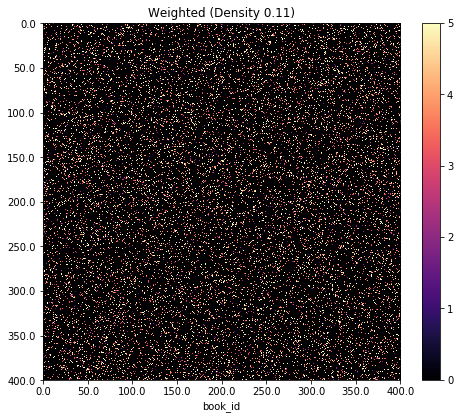

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
make_matrix_plot(ax, weighted_matrix, title='Weighted (Density 0.11)')
plt.savefig(image_output_path + 'weighted-submatrix-11.png', bbox_inches='tight', dpi=300)

In [26]:
del weighted_matrix

A better approach to a random model, which may be more comparable to the baseline model below, would be to sample from the ratings distribution "along rows" weighted by book popularity, as a proportion of total ratings, "along columns".

## Baseline Model

Take the mean rating for each book as the value along each column of the matrix completion $A$.

In [27]:
mean_matrix_column = np.array(ratings_matrix.mean(axis=0))

In [28]:
mean_matrix_column.shape

(1, 10000)

In [29]:
baseline_matrix = np.repeat(mean_matrix_column,
                            ratings_matrix.shape[0],
                            axis=0)

scores['baseline'] = {
    'rmse': compute_scores(baseline_matrix, sparse=False,
                           density=False)['rmse'],
    'density': 1
}

The RMSE between the matrix and the user-book ratings matrix is: 9584.66


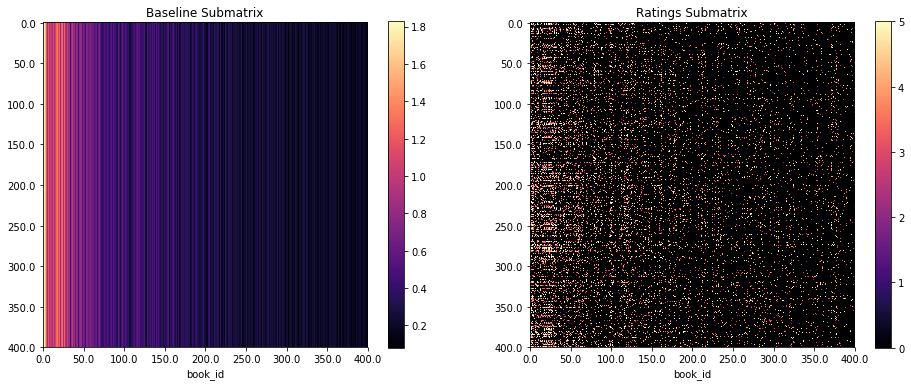

In [30]:
baseline_matrix_plot = np.repeat(mean_matrix_column, 500, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          baseline_matrix_plot,
                          sparse=False,
                          shrink=0.75,
                          title='Baseline Submatrix')
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'baseline-matrix.png', bbox_inches='tight', dpi=300)

In [31]:
del baseline_matrix, mean_matrix_column

In [32]:
# Mean of columns over nonzeros only as baseline?
# Would have to do some weighting by book popularity
# sums = ratings_matrix.sum(axis=0)
# counts = ratings_matrix.getnnz(axis=0)
# average_book_ratings = sums / counts

In [33]:
# np.linalg.norm(ratings_matrix - np.repeat(average_book_ratings, ratings_matrix.shape[0], axis=0))

## Factorizations

We can think of $W$ as a matrix of user preferences for book profiles. A row $w_u$ of $W$ is a vector of length $k$ which describes the degree to which each of the $k$ latent factors influences user preferences for books. Similarly, a column $h_b$ of $H$ describes the degree to which each of the $k$ latent factors influences that book's preferences by users.

The dot product $a_{ub} = w_u h_b^T$ captures the correlation between user $u$ and and book $b$ so that the matrix $A = WH$ we can consider to be a 'completion' of $V$.

### $k=1$

Choosing a number of latent factors $k=1$ acts as a sort of baseline model as well. In this case $H$ is a vector of book ratings aggregated by user – while $W$ gives the component of each user in the $H$ 'direction'. In other words, $W$ describes how 'close' each user's ratings are to the aggregated book ratings. The vector $H$ is highly correlated to the column means of the baseline model, so recommendations from these two models are very similar, but the $k=1$ model scores better since it also takes into account how much each user's ratings are correlated to the aggregated book ratings. We now have not only a row vector of book rating means but a column vector of user correlations to the aggregated book ratings.

In [34]:
# Set the number of latent factors
n_components=1

In [35]:
from sklearn.decomposition import NMF
from datetime import datetime

In [36]:
model = NMF(n_components=n_components,
            random_state=20190719,
#            alpha=300,
#            l1_ratio=0.9
           )

In [37]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:25:54.786717
2019-07-21 02:25:56.806476


In [38]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {
    'rmse': model.reconstruction_err_,
    'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])
}

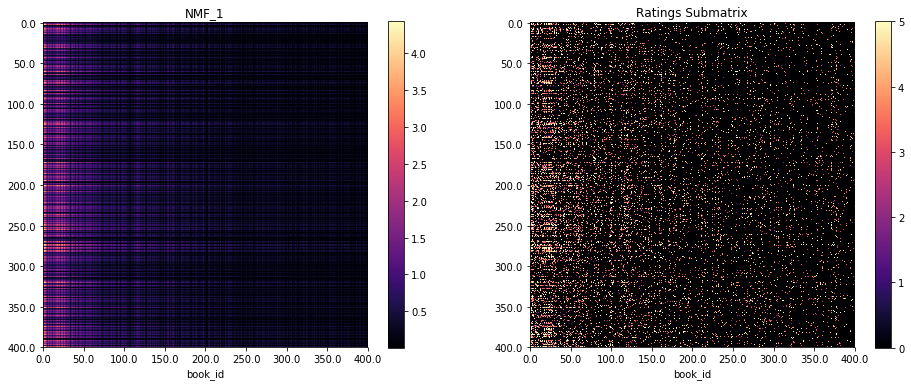

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png', bbox_inches='tight', dpi=300)

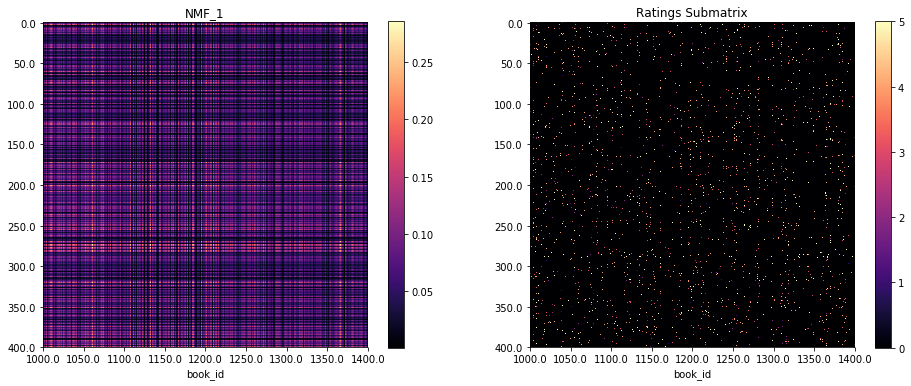

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '.png', bbox_inches='tight', dpi=300)

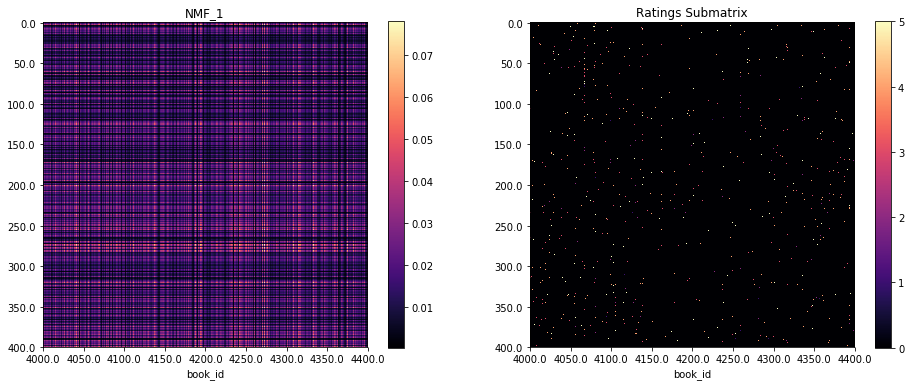

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0], A, sparse=False,
                          shrink=0.75, col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1], ratings_matrix,
                          shrink=0.75, col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '.png', bbox_inches='tight', dpi=300)

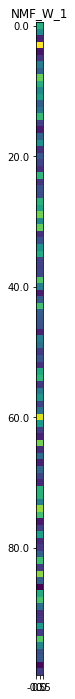

In [43]:
fig, ax = plt.subplots(figsize=(2,12))
make_matrix_plot(ax, W, sparse=False, cmap='viridis',
                 row_size=100, col_size=n_components,
                colorbar=False, xlabel=None,
                title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

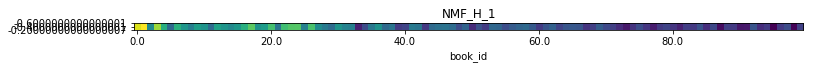

In [44]:
fig, ax = plt.subplots(figsize=(12,2))
make_matrix_plot(ax, H, sparse=False, cmap='viridis',
                 col_size=100, row_size=n_components,
                 colorbar=False, ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

In [45]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' 
      + '{:,}'.format(W.nbytes + H.nbytes)
      + ' bytes.')

The model memory usage is: 507,392 bytes.


### $k=10$

Now let's try a few values for $k$. Lesser values of $k$ give more interpretable models whereas greater values of $k$ give more accurate models.

In [46]:
n_components=10

In [47]:
model = NMF(n_components=n_components,
            random_state=20190719,
#            alpha=230,
#            l1_ratio=0.9
           )

In [48]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:26:06.063098
2019-07-21 02:26:33.425487


In [49]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {'rmse': model.reconstruction_err_,
                   'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])}

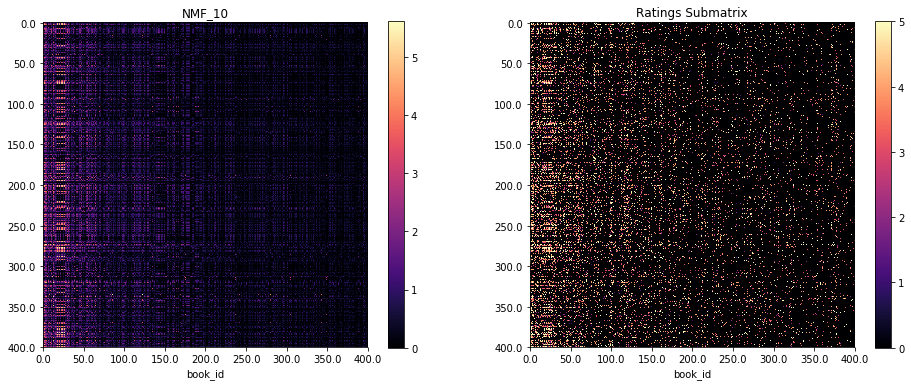

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png',
            bbox_inches='tight',
            dpi=300)

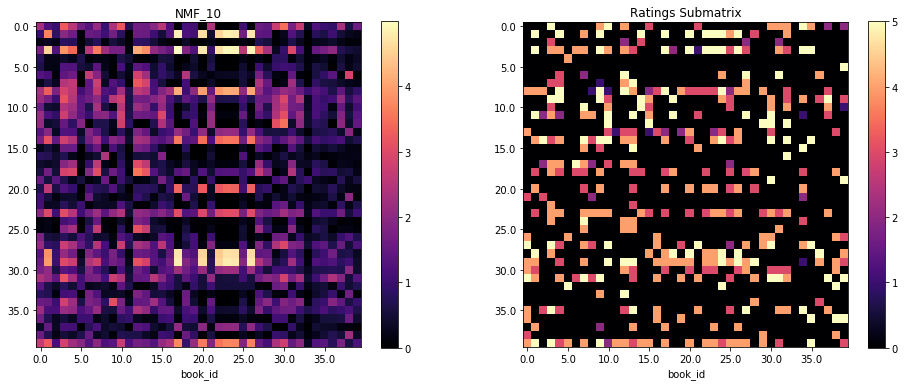

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' +
            '-close' + '.png',
            bbox_inches='tight',
            dpi=300)

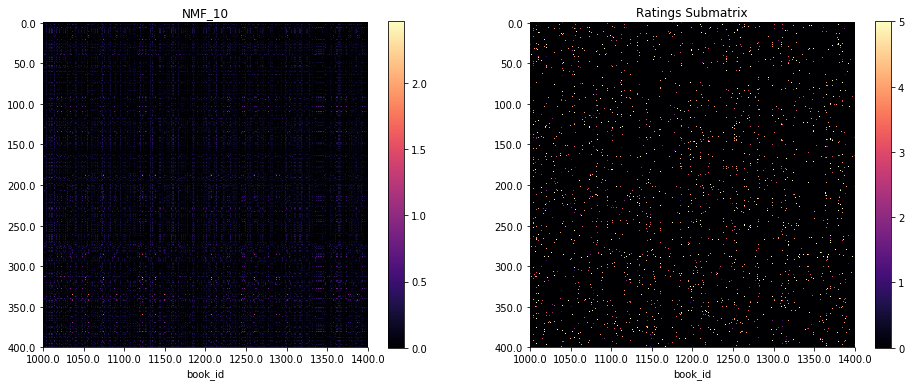

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' +
            '-center' + '.png',
            bbox_inches='tight',
            dpi=300)

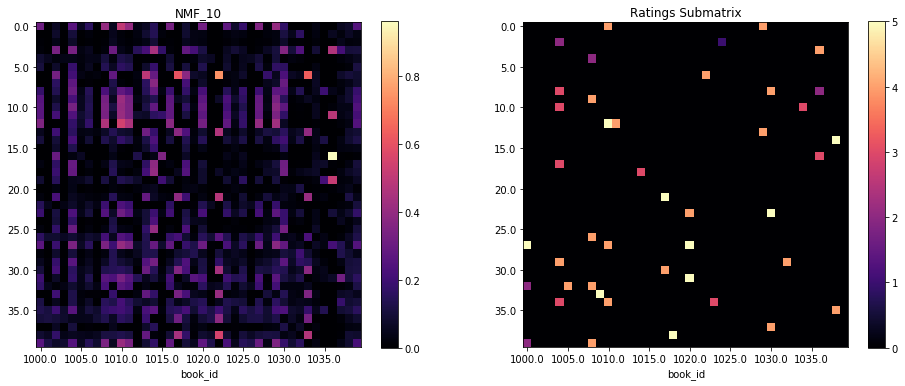

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' +
            '-center' + '-close' + '.png',
            bbox_inches='tight',
            dpi=300)

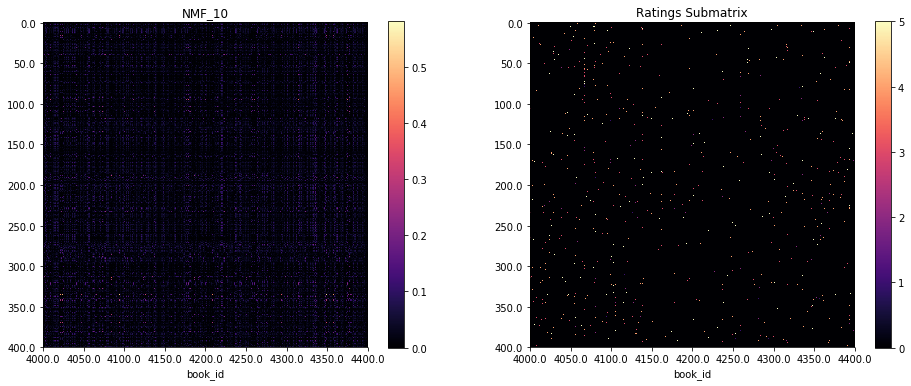

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' +
            '.png',
            bbox_inches='tight',
            dpi=300)

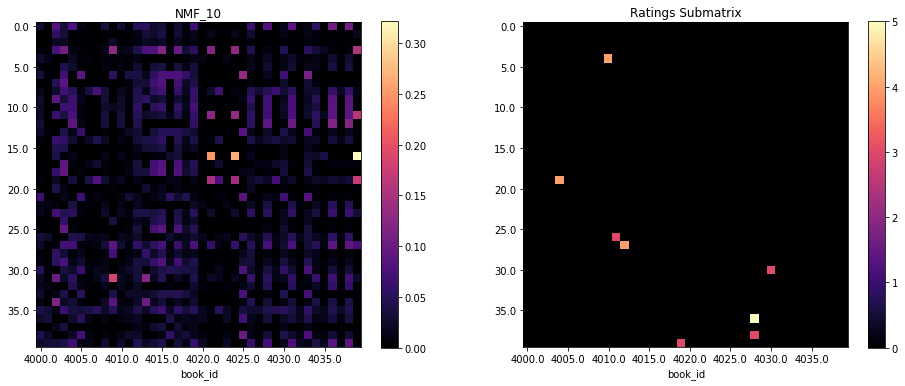

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' +
            '-close' + '.png',
            bbox_inches='tight',
            dpi=300)

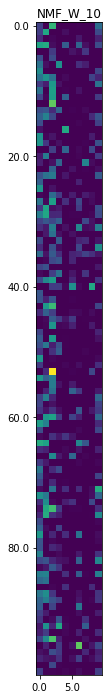

In [56]:
fig, ax = plt.subplots(figsize=(2, 12))
make_matrix_plot(ax,
                 W,
                 sparse=False,
                 cmap='viridis',
                 row_size=100,
                 col_size=n_components,
                 colorbar=False,
                 xlabel=None,
                 title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png',
            bbox_inches='tight',
            dpi=300)

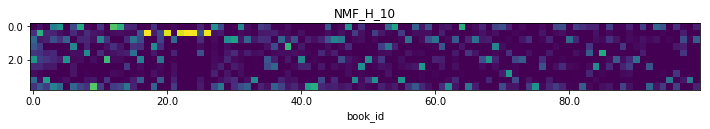

In [57]:
fig, ax = plt.subplots(figsize=(12, 2))
make_matrix_plot(ax,
                 H,
                 sparse=False,
                 cmap='viridis',
                 col_size=100,
                 row_size=n_components,
                 colorbar=False,
                 ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png',
            bbox_inches='tight',
            dpi=300)

In [58]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' + '{:,}'.format(W.nbytes + H.nbytes) +
      ' bytes.')

The model memory usage is: 5,073,920 bytes.


### $k=25$

In [59]:
n_components=25

In [60]:
model = NMF(
    n_components=n_components,
    random_state=20190719,
    #            alpha=230,
    #            l1_ratio=0.9
)

In [61]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:26:46.586076
2019-07-21 02:27:27.363460


In [62]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {
    'rmse': model.reconstruction_err_,
    'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])
}

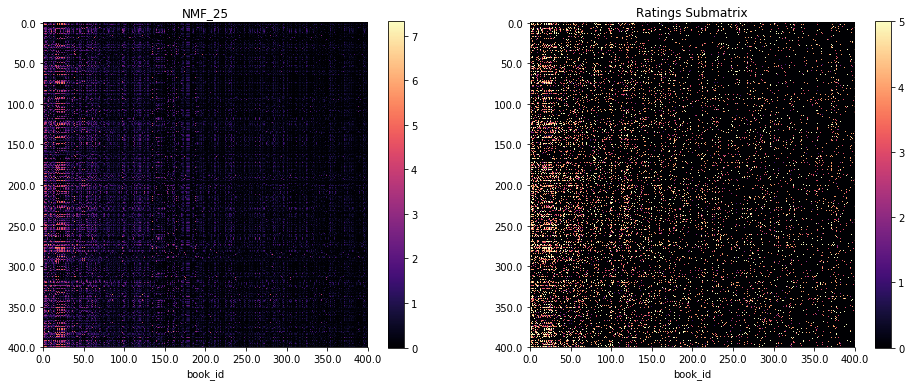

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png',
            bbox_inches='tight',
            dpi=300)

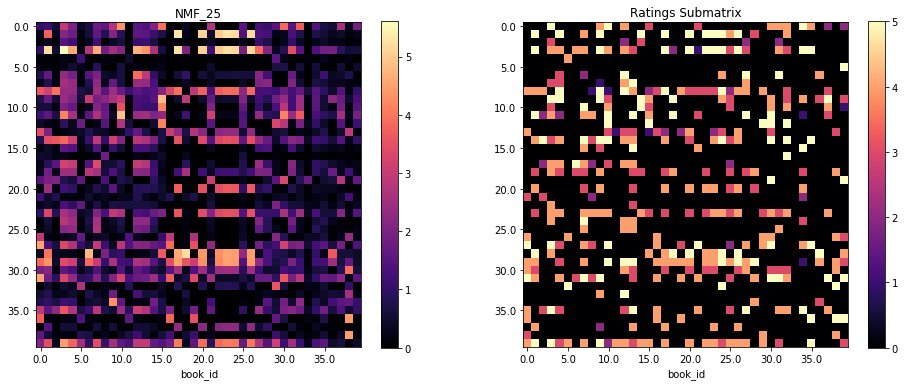

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-close' + '.png', bbox_inches='tight', dpi=300)

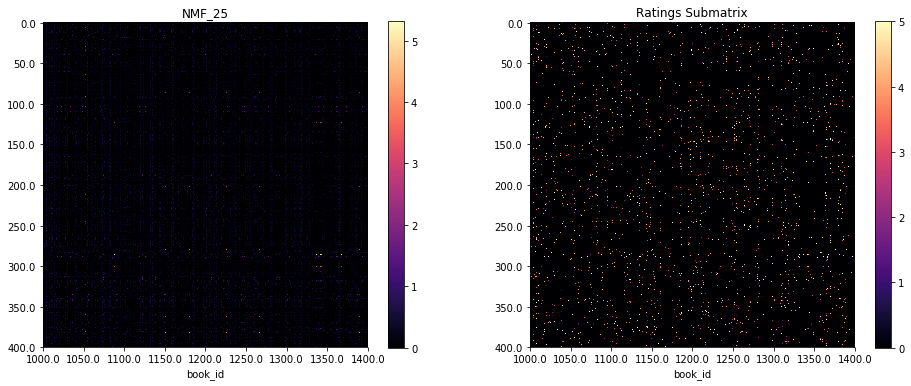

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '.png', bbox_inches='tight', dpi=300)

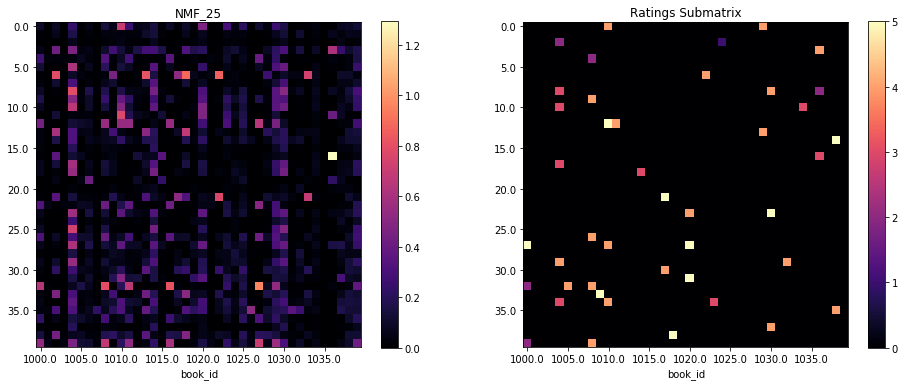

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

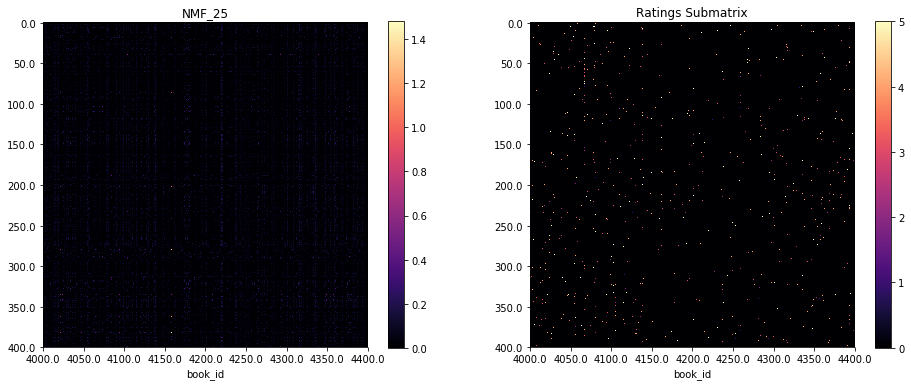

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '.png', bbox_inches='tight', dpi=300)

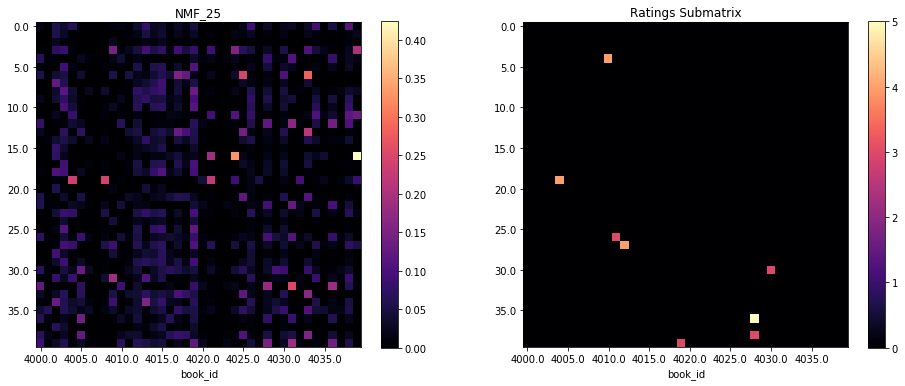

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

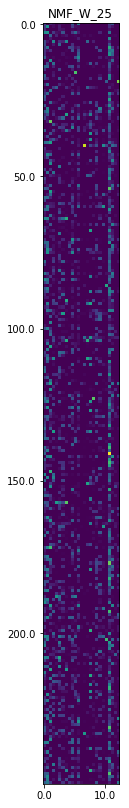

In [69]:
fig, ax = plt.subplots(figsize=(2, 14))
make_matrix_plot(ax,
                 W,
                 sparse=False,
                 cmap='viridis',
                 row_size=250,
                 col_size=n_components,
                 colorbar=False,
                 xlabel=None,
                 title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

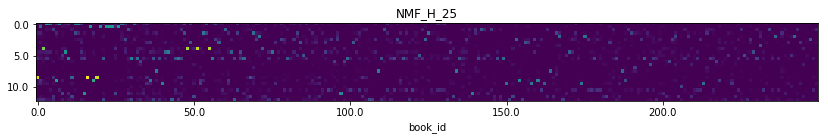

In [70]:
fig, ax = plt.subplots(figsize=(14, 2))
make_matrix_plot(ax,
                 H,
                 sparse=False,
                 cmap='viridis',
                 col_size=250,
                 row_size=n_components,
                 colorbar=False,
                 ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

In [71]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' + '{:,}'.format(W.nbytes + H.nbytes) +
      ' bytes.')

The model memory usage is: 12,684,800 bytes.


### $k=50$

In [72]:
n_components=50

In [73]:
model = NMF(
    n_components=n_components,
    random_state=20190719,
    #             alpha=100,
    #             l1_ratio=0.999
)

In [74]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:27:41.907227
2019-07-21 02:29:29.461502


In [75]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {
    'rmse': model.reconstruction_err_,
    'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])
}

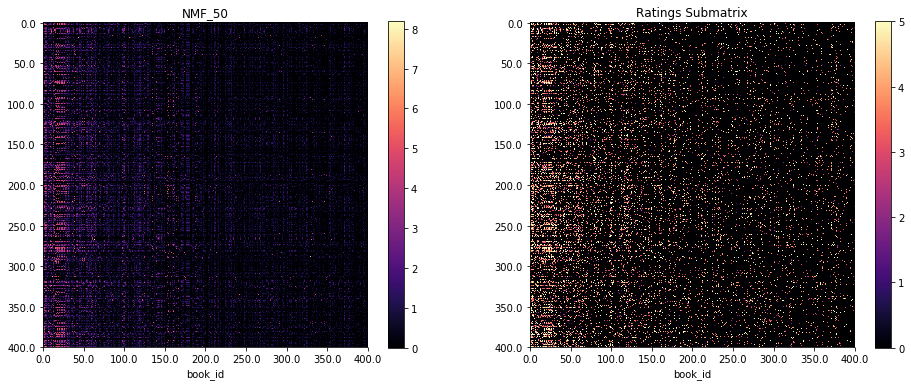

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png', bbox_inches='tight', dpi=300)

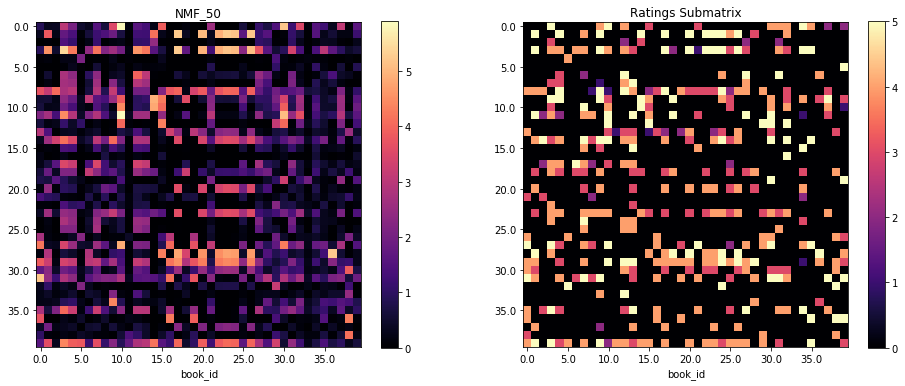

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-close' + '.png', bbox_inches='tight', dpi=300)

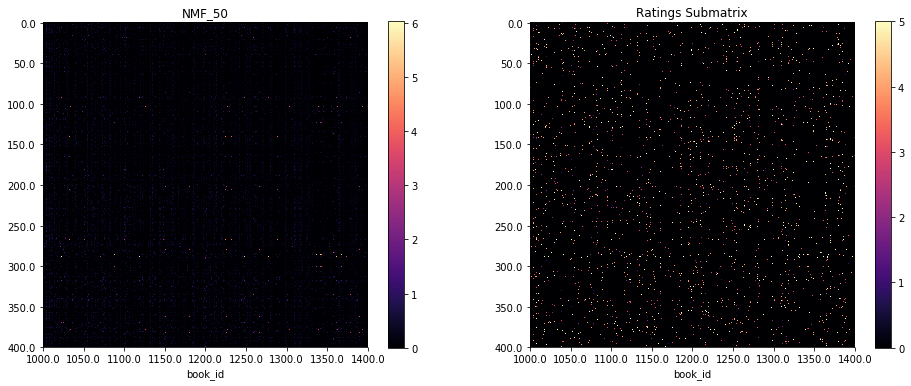

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '.png', bbox_inches='tight', dpi=300)

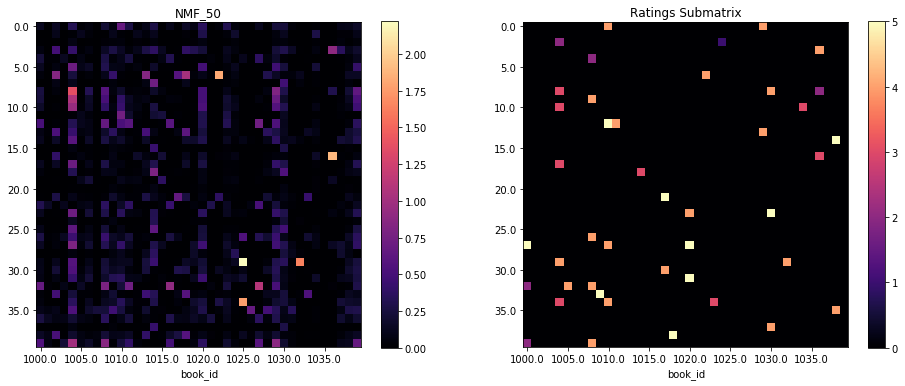

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

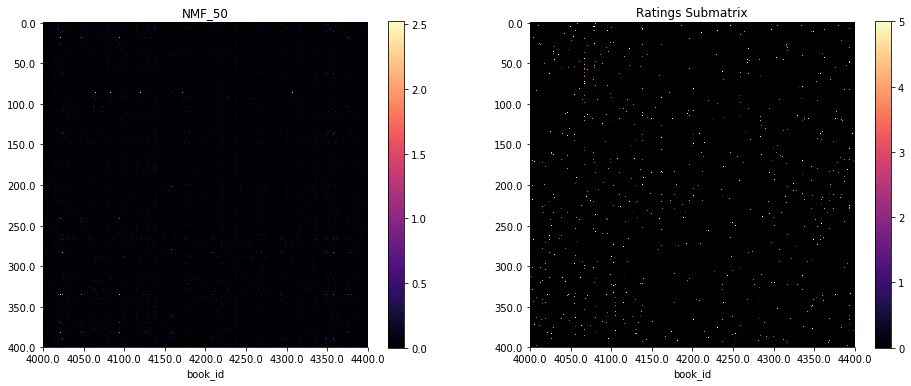

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '.png', bbox_inches='tight', dpi=300)

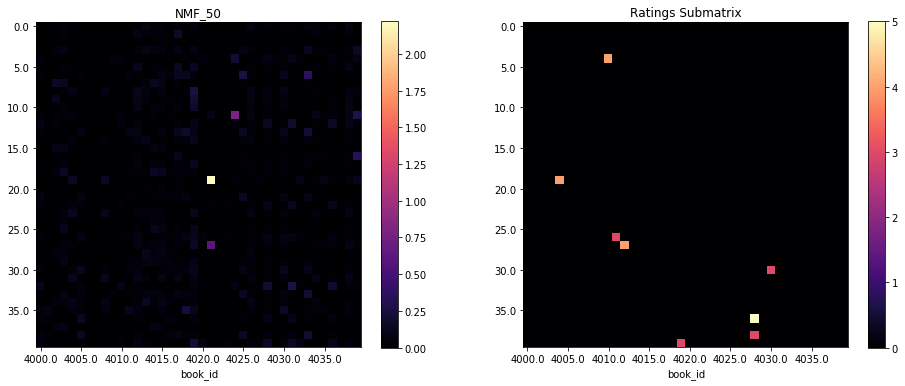

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

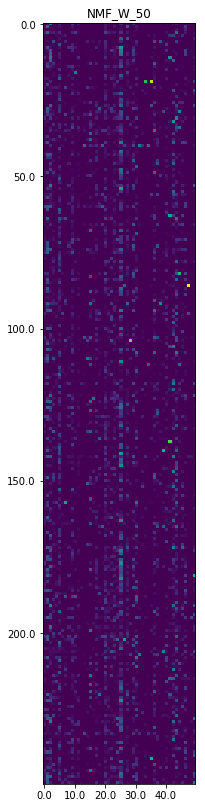

In [82]:
fig, ax = plt.subplots(figsize=(4, 14))
make_matrix_plot(ax,
                 W,
                 sparse=False,
                 cmap='viridis',
                 row_size=250,
                 col_size=n_components,
                 colorbar=False,
                 xlabel=None,
                 title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

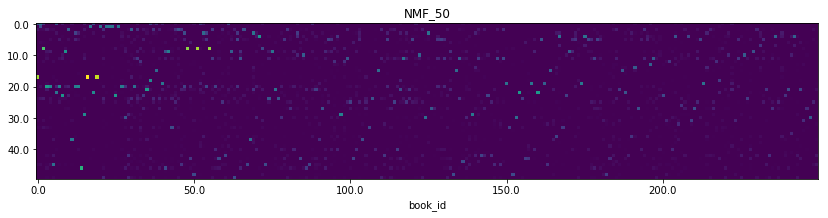

In [83]:
fig, ax = plt.subplots(figsize=(14, 4))
make_matrix_plot(ax,
                 H,
                 sparse=False,
                 cmap='viridis',
                 col_size=250,
                 row_size=n_components,
                 colorbar=False,
                 ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

In [84]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' + '{:,}'.format(W.nbytes + H.nbytes) +
      ' bytes.')

The model memory usage is: 25,369,600 bytes.


### $k=100$

In [85]:
n_components=100

In [86]:
model = NMF(n_components=n_components,
            random_state=20190719,
#             alpha=100,
#             l1_ratio=0.999
           )

In [87]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:29:45.668079
2019-07-21 02:37:35.463239


In [88]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {'rmse': model.reconstruction_err_,
                   'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])}

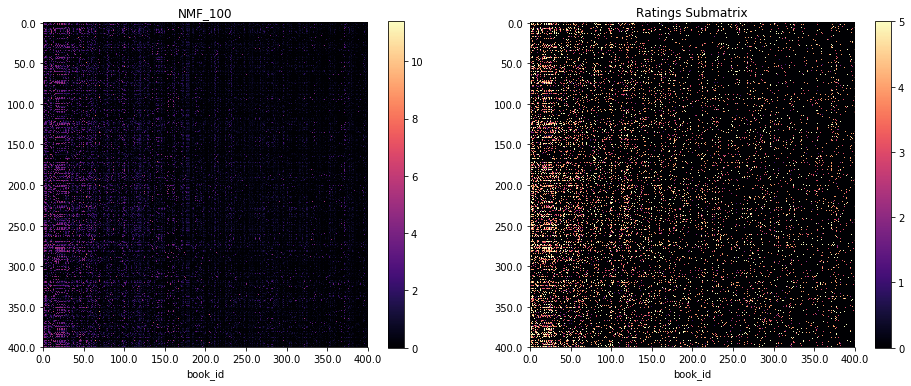

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png', bbox_inches='tight', dpi=300)

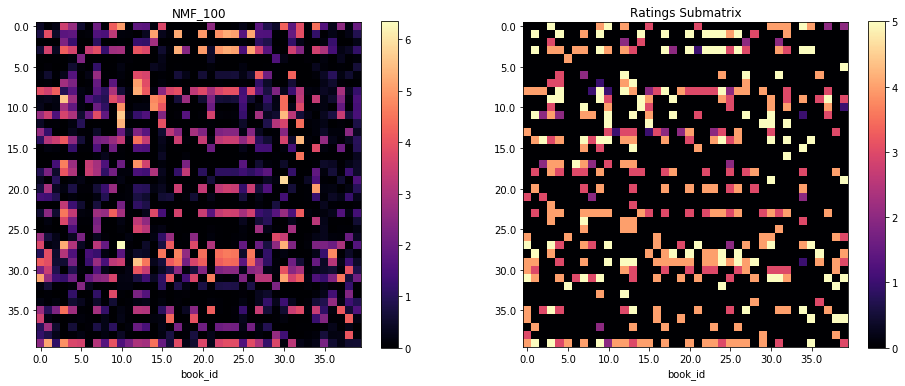

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-close' + '.png', bbox_inches='tight', dpi=300)

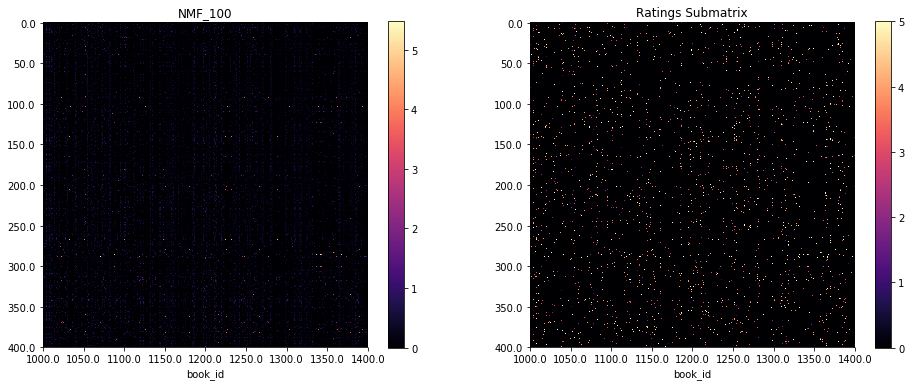

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '.png', bbox_inches='tight', dpi=300)

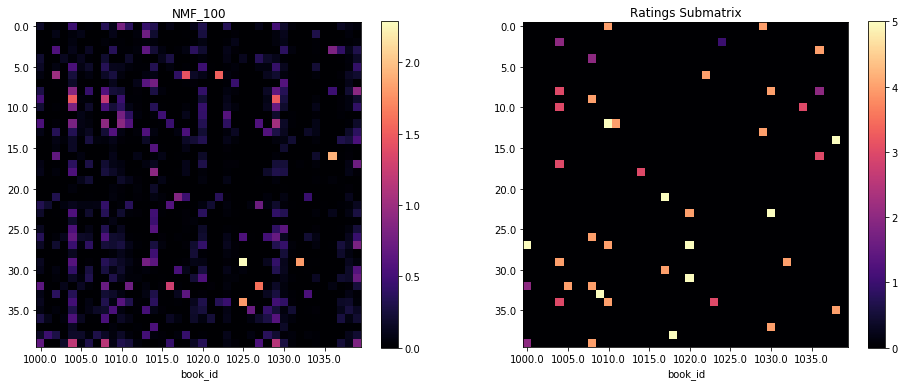

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

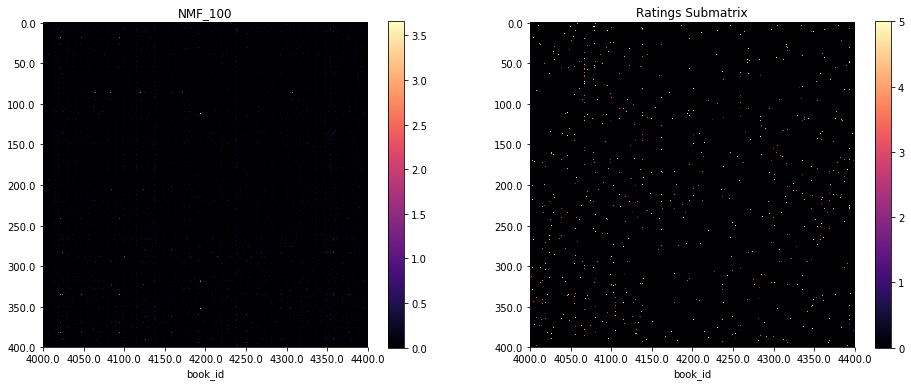

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '.png', bbox_inches='tight', dpi=300)

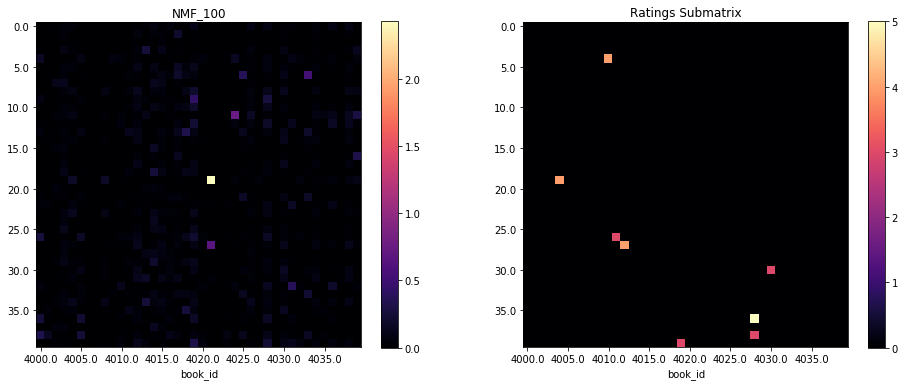

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

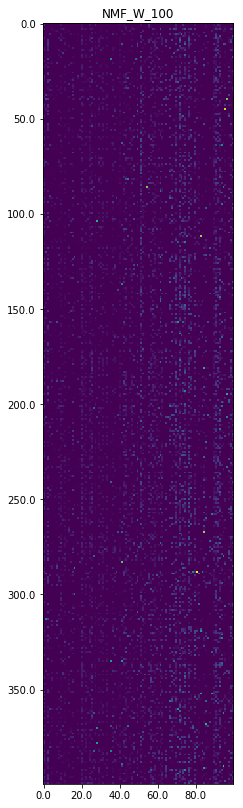

In [95]:
fig, ax = plt.subplots(figsize=(4, 14))
make_matrix_plot(ax,
                 W,
                 sparse=False,
                 cmap='viridis',
                 row_size=400,
                 col_size=n_components,
                 colorbar=False,
                 xlabel=None,
                 title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

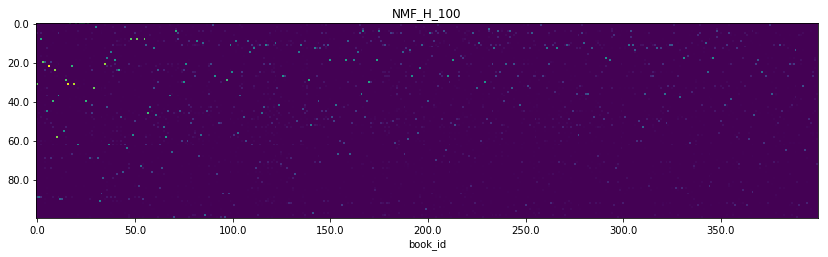

In [96]:
fig, ax = plt.subplots(figsize=(14, 4))
make_matrix_plot(ax,
                 H,
                 sparse=False,
                 cmap='viridis',
                 col_size=400,
                 row_size=n_components,
                 colorbar=False,
                 ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

In [97]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' + '{:,}'.format(W.nbytes + H.nbytes) +
      ' bytes.')

The model memory usage is: 50,739,200 bytes.


### $k=250$

In [98]:
n_components = 250

In [99]:
model = NMF(
    n_components=n_components,
    random_state=20190719,
    #             alpha=100,
    #             l1_ratio=0.999
)

In [100]:
print(datetime.now())
W = model.fit_transform(ratings_matrix)
print(datetime.now())

H = model.components_

2019-07-21 02:37:55.607309
2019-07-21 03:14:03.746798


In [101]:
A = model.inverse_transform(W)

scores['NMF_' + str(n_components)] = {
    'rmse': model.reconstruction_err_,
    'density': np.count_nonzero(A) / (A.shape[0] * A.shape[1])
}

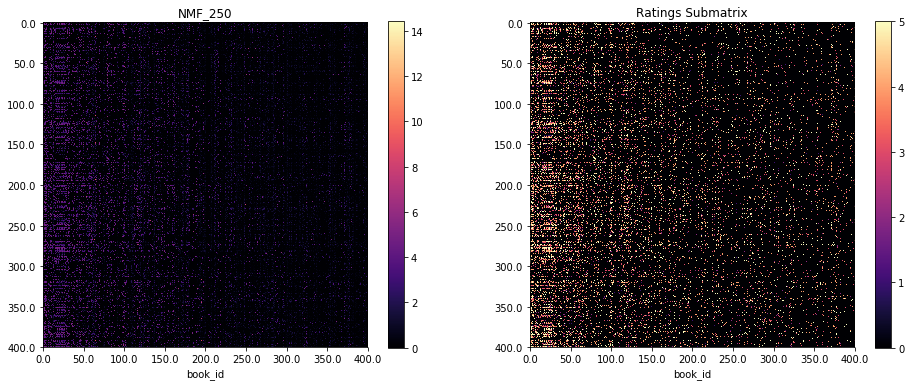

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '.png', bbox_inches='tight', dpi=300)

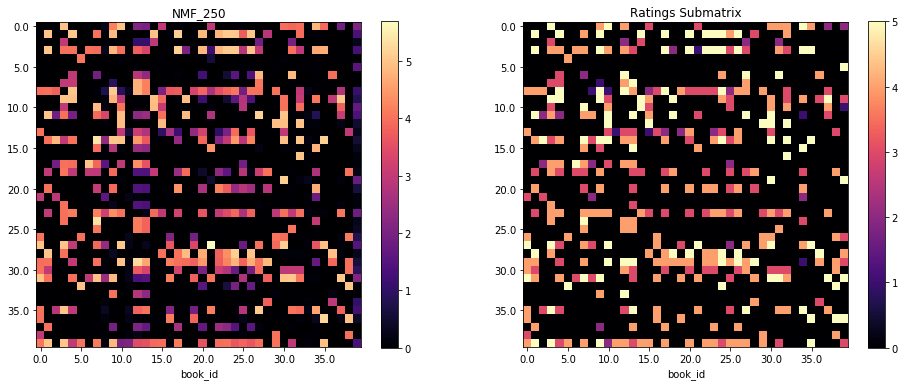

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-close' + '.png', bbox_inches='tight', dpi=300)

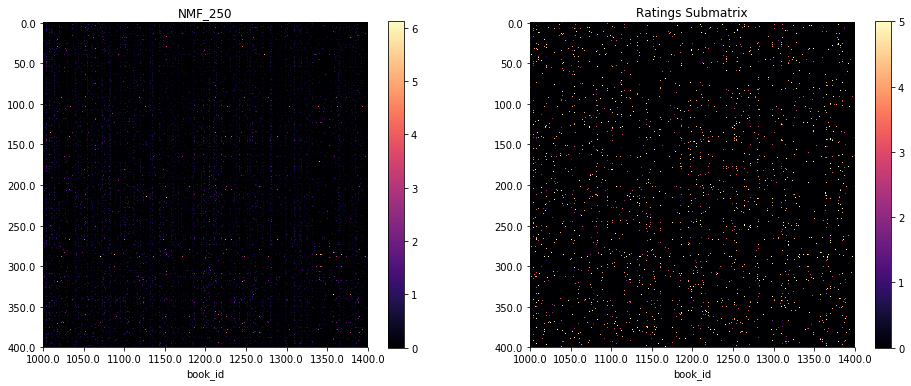

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '.png', bbox_inches='tight', dpi=300)

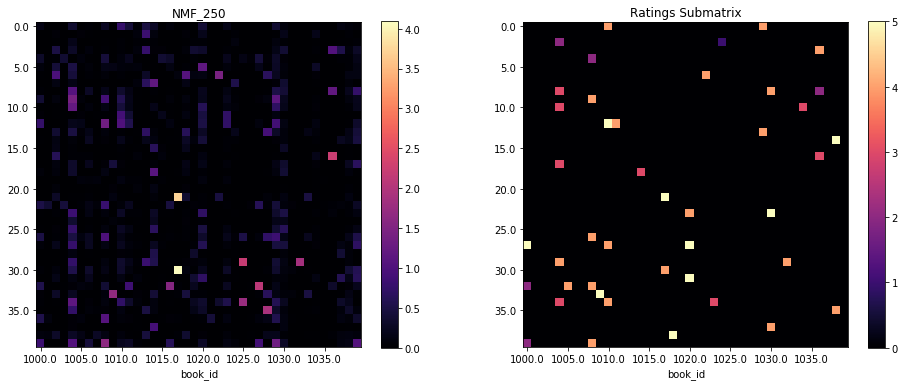

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 1000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-left' + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

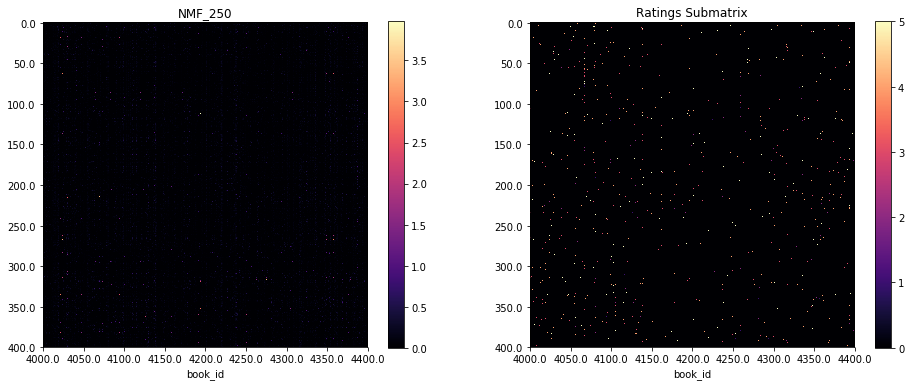

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '.png', bbox_inches='tight', dpi=300)

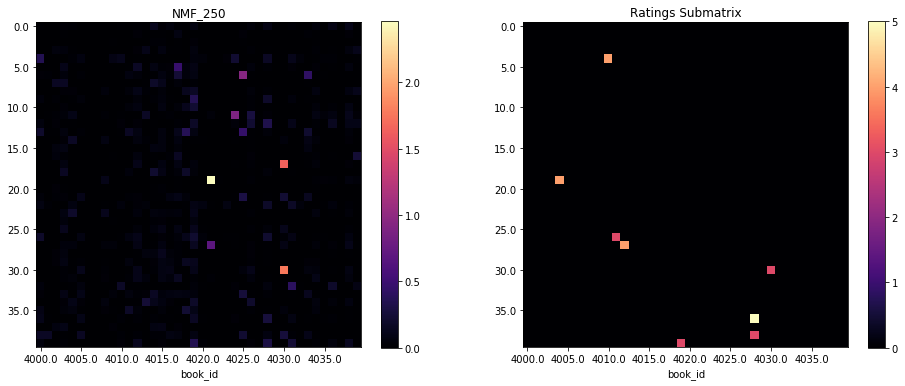

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

col_shift = 4000
axs[0] = make_matrix_plot(axs[0],
                          A,
                          sparse=False,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='NMF_' + str(n_components))
axs[1] = make_matrix_plot(axs[1],
                          ratings_matrix,
                          row_size=40,
                          col_size=40,
                          shrink=0.75,
                          col_shift=col_shift,
                          title='Ratings Submatrix')
plt.savefig(image_output_path + 'nmf-' + str(n_components) + '-center' + '-close' + '.png', bbox_inches='tight', dpi=300)

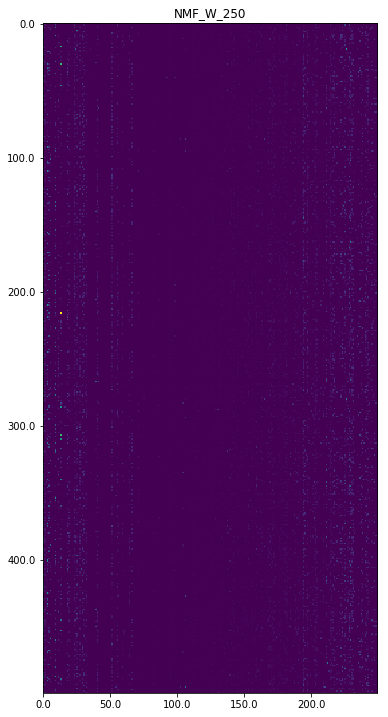

In [108]:
fig, ax = plt.subplots(figsize=(6, 16))
make_matrix_plot(ax,
                 W,
                 sparse=False,
                 cmap='viridis',
                 row_size=500,
                 col_size=n_components,
                 colorbar=False,
                 xlabel=None,
                 title='NMF_W_' + str(n_components))
plt.savefig(image_output_path + 'nmf-W-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

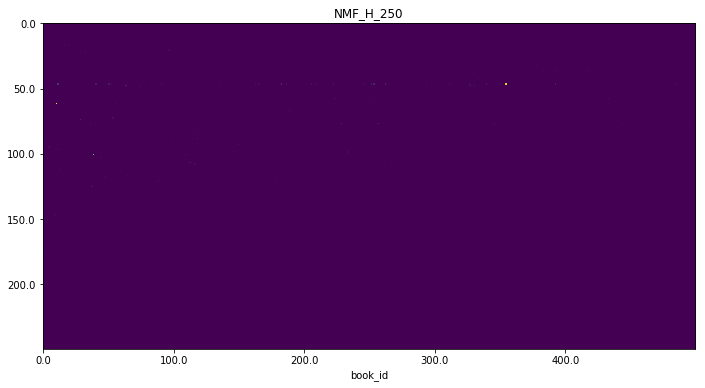

In [109]:
fig, ax = plt.subplots(figsize=(16, 6))
make_matrix_plot(ax,
                 H,
                 sparse=False,
                 cmap='viridis',
                 col_size=500,
                 row_size=n_components,
                 colorbar=False,
                 ylabel=None,
                 title='NMF_H_' + str(n_components))
plt.savefig(image_output_path + 'nmf-H-' + str(n_components) + '.png', bbox_inches='tight', dpi=300)

In [110]:
# Save model (W and H) to file
np.savetxt(model_output_path + 'W_' + str(n_components) + '.csv', W)
np.savetxt(model_output_path + 'H_' + str(n_components) + '.csv', H)

print('The model memory usage is: ' + '{:,}'.format(W.nbytes + H.nbytes) +
      ' bytes.')

The model memory usage is: 126,848,000 bytes.


## Scores
We'll plot the RMSEs of the models.

In [111]:
import seaborn as sns

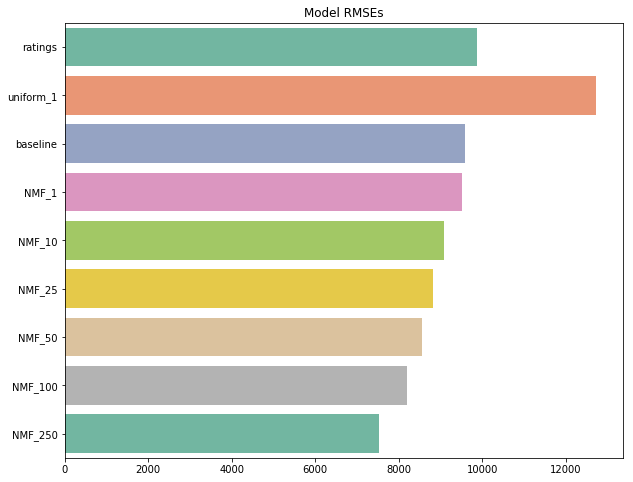

In [112]:
names = []
rmses = []

for key, val in scores.items():
    if key not in ['uniform_10', 'weighted_1']:
        names.append(key)
        rmses.append(val['rmse'])

plt.figure(figsize=(10, 8))
sns.barplot(x='RMSE',
            y='model',
            data=pd.Series(data={
                'model': names,
                'RMSE': rmses
            }),
            palette='Set2')
plt.title('Model RMSEs')
plt.savefig(image_output_path + 'model-rmses.png', bbox_inches='tight', dpi=300)